# Desafío Spike

Este notebook presenta la solución para el desafío de precios de Spike. Todos los detalles del desafío están en el archivo `Spike_Challenge_precios.pdf`.

## 0. Setup de librerías

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import sweetviz as sv
%matplotlib inline
import plotly.express as px
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from math import sqrt

## 1. Importación de datos
Se comienza revisando los datos de precipitaciones:

In [2]:
df_precipitaciones = pd.read_csv("data/precipitaciones.csv")

In [3]:
def set_datetime_index(data: pd.DataFrame, dt_column: str) -> pd.DataFrame:
    """
    Recibe un dataframe y un nombre de columna, retorna el dataframe con esa columna
    transformada a datetime como index
    """
    df = data.copy()
    df['_date'] = pd.to_datetime(pd.to_datetime(df[dt_column]).dt.date)
    df = df.set_index(df['_date'])
    df = df.drop('_date', axis=1)
    df = df.sort_values(by='_date', ascending=True)
    return df

In [4]:
df_precipitaciones = set_datetime_index(df_precipitaciones, 'date') 
print("Revisión visual de las primeras filas de los datos de precipitaciones:")
df_precipitaciones.head()

Revisión visual de las primeras filas de los datos de precipitaciones:


date   Coquimbo  Valparaiso  Metropolitana_de_Santiago  \
_date                                                                      
1979-01-01  1979-01-01   2.641948    0.587062                   2.447114   
1979-02-01  1979-02-01   1.179804    2.432192                   3.997852   
1979-03-01  1979-03-01   0.255490    0.020601                   0.000000   
1979-04-01  1979-04-01  10.173699   11.745779                  13.722349   
1979-05-01  1979-05-01   1.039098   18.609286                  50.187148   

            Libertador_Gral__Bernardo_O_Higgins       Maule      Biobio  \
_date                                                                     
1979-01-01                             1.608992    3.736215   17.859634   
1979-02-01                             4.346310   16.347637   17.680612   
1979-03-01                             0.055488    0.545324   14.435698   
1979-04-01                            12.989194   21.880607   39.136483   
1979-05-01                           104.451550  143.914334  219.729235   

            La_Araucania    Los_Rios  
_date                                 
1979-01-01     25.212940   45.596447  
1979-02-01     18.085072   34.075039  
1979-03-01     28.696504   66.232248  
1979-04-01     43.617921   73.548127  
1979-05-01    279.409718  438.005116

En primer lugar se utiliza sweetviz para crear un reporte rápido de los datos de precipitaciones que queda en el archivo `report/precipitaciones.html`.

In [5]:
reporte_precipitaciones = sv.analyze(df_precipitaciones)
reporte_precipitaciones.show_html("report/precipitaciones.html")

                                             |          | [  0%]   00:00 -> (? left)

Report report/precipitaciones.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Del reporte, se ve que hay 496 datos de distintas regiones del país, con algunas observaciones:
1. No hay valores nulos! Un motivo para celebrar, pero si hay 0 precipitaciones en algunos meses, lo que no suena muy creíble. Pero, abajo vemos que cada vez que en un mes hay 0 precipitaciones en una región, las regiones cercanas también tiene valores pequeños. Por ejemplo, cuando la región Metropolitana tiene 0 precipitaciones, Valparaíso y Ohiggins tienen menos de 1 mm. Por esto, se asume que esos valores en 0 son correctos.

In [6]:
df_precipitaciones[(df_precipitaciones.T == 0).any()].head()

date  Coquimbo  Valparaiso  Metropolitana_de_Santiago  \
_date                                                                     
1979-03-01  1979-03-01  0.255490    0.020601                   0.000000   
1979-06-01  1979-06-01  0.141157    0.000000                   1.397164   
1982-04-01  1982-04-01  0.000000    0.019610                   6.848607   
1983-12-01  1983-12-01  0.540072    0.000000                   0.021141   
1988-10-01  1988-10-01  0.000000    0.019886                   4.621711   

            Libertador_Gral__Bernardo_O_Higgins      Maule     Biobio  \
_date                                                                   
1979-03-01                             0.055488   0.545324  14.435698   
1979-06-01                             7.378558  28.797945  72.501902   
1982-04-01                            16.891752  28.904933  41.035299   
1983-12-01                             0.689364   4.589584   7.305120   
1988-10-01                             8.260992  27.616980  69.572460   

            La_Araucania    Los_Rios  
_date                                 
1979-03-01     28.696504   66.232248  
1979-06-01    113.488705  179.949832  
1982-04-01     47.870769   89.875426  
1983-12-01     28.036984   40.091654  
1988-10-01    133.732635  181.879767

2. Se aprecian correlaciones altas entre muchas de las regiones. al observarlas en la siguiete matriz, se evidencia que prácticamente todas las regiones tienen una considerable correlación positiva, siendo mayor en las regiones más cercanas.

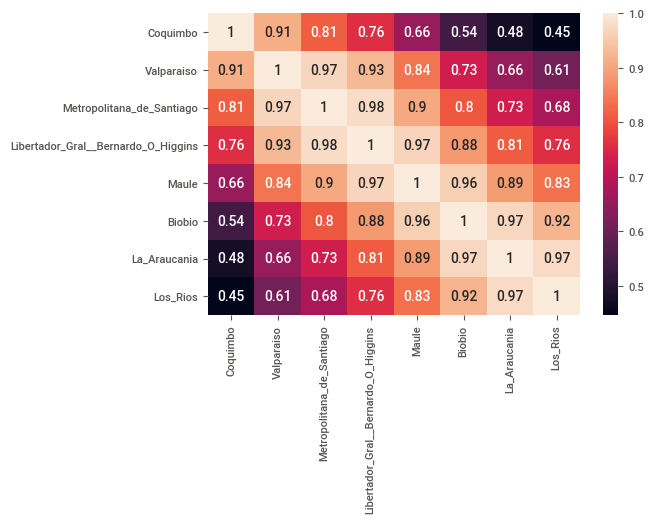

In [7]:
sns.heatmap(df_precipitaciones.corr(), annot=True)
plt.show()

3. Con un simple boxplot se puede verificar que hay regiones que tienen mayores cantidad de precipitaciones en promedio (las del sur de Chile) y que hay varios datos de precipitaciones extremos, por sobre el IQR que muestra por defecto el boxplot.

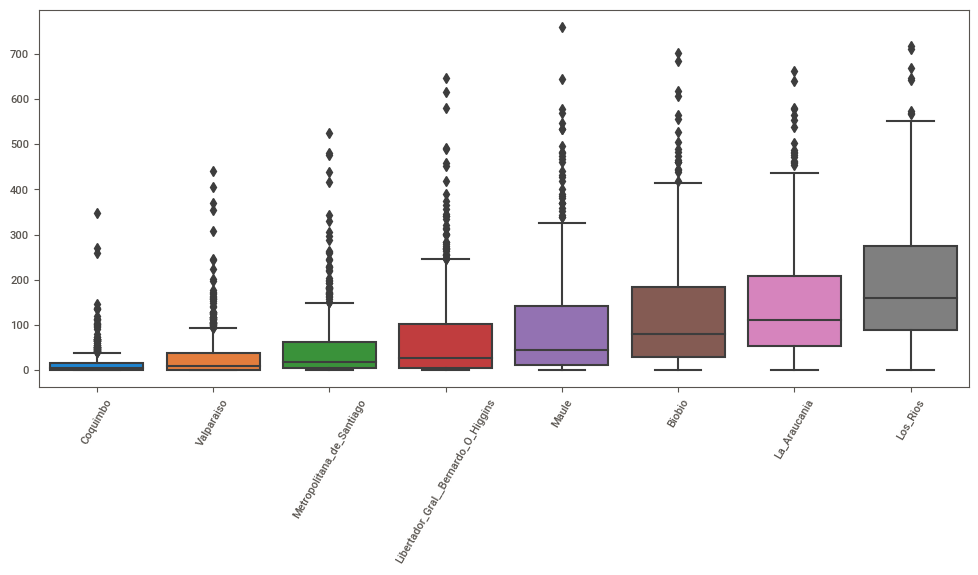

In [8]:
plt.figure(figsize = (12, 5))
sns.boxplot(data=df_precipitaciones)
plt.xticks(rotation=60);
plt.show()

Ahora, se revisan los datos del Banco Central:

In [9]:
df_banco_central = pd.read_csv("data/banco_central.csv")

Al intentar convertir la columna de Periodo en una fecha, se encuentra que existe una columna con el mes 13 en el 2020 que es eliminada.

In [10]:
df_banco_central = df_banco_central[df_banco_central['Periodo']<='2020-12-01']
print("Revisión visual de las primeras filas de los datos del banco central:")
df_banco_central.head()

Revisión visual de las primeras filas de los datos del banco central:


Periodo Imacec_empalmado Imacec_produccion_de_bienes  \
0  2013-03-01 00:00:00 UTC      102.796.218                  10.546.824   
1  2013-04-01 00:00:00 UTC      101.664.842                 999.272.757   
2  2013-05-01 00:00:00 UTC      101.642.954                 993.959.922   
3  2013-06-01 00:00:00 UTC      998.310.201                 968.367.884   
4  2013-07-01 00:00:00 UTC      964.696.194                 961.051.418   

  Imacec_minero Imacec_industria Imacec_resto_de_bienes Imacec_comercio  \
0   978.554.365      102.297.537            114.994.919     110.729.395   
1   927.333.293      104.485.589            102.199.311     106.098.291   
2    96.133.164      105.445.361            968.789.055     100.462.117   
3   102.400.933      999.212.106             89.190.493     939.504.414   
4   980.029.022      100.882.112            901.785.886      92.776.599   

  Imacec_servicios Imacec_a_costo_de_factores Imacec_no_minero  ...  \
0      100.064.328                103.163.651      103.405.852  ...   
1      102.600.107                101.937.319      102.766.884  ...   
2      104.083.216                101.953.299      102.322.796  ...   
3      103.857.161                100.222.381      995.139.235  ...   
4      969.309.272                962.069.134      962.804.305  ...   

  Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100  \
0                                        865.903.468      
1                                        867.806.065      
2                                        878.030.947      
3                                        913.180.348      
4                                        909.263.447      

  Indice_de_produccion_industrial Indice_de_produccion_industrial__mineria  \
0                     102.761.705                               98.915.705   
1                     968.087.179                              914.276.663   
2                     978.471.874                              966.913.278   
3                     966.647.135                              981.820.974   
4                     100.100.749                              990.198.382   

  Indice_de_produccion_industrial_electricidad__gas_y_agua  \
0                                                NaN         
1                                                NaN         
2                                                NaN         
3                                                NaN         
4                                                NaN         

  Indice_de_produccion_industrial__manufacturera  \
0                                    108.387.837   
1                                    104.545.429   
2                                     99.468.801   
3                                     94.969.678   
4                                    102.128.977   

  Generacion_de_energia_electrica_CDEC_GWh  \
0                              580.480.672   
1                              544.815.032   
2                               56.891.916   
3                               56.594.867   
4                              586.329.899   

  Indice_de_ventas_comercio_real_IVCM  \
0                                 NaN   
1                                 NaN   
2                                 NaN   
3                                 NaN   
4                                 NaN   

  Indice_de_ventas_comercio_real_no_durables_IVCM  \
0                                             NaN   
1                                             NaN   
2                                             NaN   
3                                             NaN   
4                                             NaN   

  Indice_de_ventas_comercio_real_durables_IVCM Ventas_autos_nuevos  
0                                          NaN             28577.0  
1                                          NaN             32206.0  
2                                          NaN             31589.0  
3                                          NaN             28

Nuevamente se usa sweetviz para hacer un rápido análisis de los datos en el archivo `report/banco_central.html`.

In [11]:
reporte_banco = sv.analyze(df_banco_central)
reporte_banco.show_html("report/banco_central.html")

                                             |          | [  0%]   00:00 -> (? left)

Report report/banco_central.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


En el dataset del banco central se tienen datos desde el año 1970 hasta el año 2020 de distintos indicadores económicos. Principalmente Imacec y PIB por sectores, además de otros diversos indicadores. Se encuentran los siguientes problemas:
1. Hay algunos periodos repetidos, cuyos datos son idénticos, por lo que simplemente se elimina una observacción.

In [12]:
df_banco_central = df_banco_central.drop_duplicates('Periodo', keep='first')
df_banco_central = set_datetime_index(df_banco_central, 'Periodo') 
df_banco_central.loc['2019-08-01']

Periodo                                            2019-08-01 00:00:00 UTC
Imacec_empalmado                                               113.886.371
Imacec_produccion_de_bienes                                    103.237.519
Imacec_minero                                                  106.828.407
Imacec_industria                                               105.153.122
                                                            ...           
Generacion_de_energia_electrica_CDEC_GWh                              6598
Indice_de_ventas_comercio_real_IVCM                            116.203.109
Indice_de_ventas_comercio_real_no_durables_IVCM                107.385.297
Indice_de_ventas_comercio_real_durables_IVCM                    15.342.321
Ventas_autos_nuevos                                                33059.0
Name: 2019-08-01 00:00:00, Length: 85, dtype: object

2. Observando algunos campos del PIB, en especial el PIB_Industria_Manufacturera, se ve que el valor que más se repite es la letra a, con esto se entiende por qué este campo está siendo considerado como texto por pandas. Esto se repite en el resto de indicadores. En el peor de los casos se repite 4 veces, por lo que simplemente se eliminan esos datos.

In [13]:
print((df_banco_central=="a").sum(axis=0).sort_values(ascending=False)[0:5])
df_banco_central = df_banco_central.replace({'a': np.nan})

PIB_Industria_Manufacturera                                           4
Ocupacion_en_Suministro_de_agua_evacuacion_de_aguas_residuales_INE    4
PIB_Quimica                                                           3
PIB_Agropecuario_silvicola                                            1
PIB_Minerales_no_metalicos_y_metalica_basica                          1
dtype: int64


3. Luego, se ve que el 51% de los datos el Imacec es nulo. Asimismo, el 84% de los valores del PIB también lo es. Dado que el % es igual en cada una de las variables hace pensar que la pérdida de datos es sistemática y no aleatoria. Por eso, se grafica la distribución de los valores perdidos.

    Dado que se tiene el dataset ordenado por periodo, se puede ver que el problema es que los distintos indicadores se empiezan a calcular desde distintas fechas. Por ejemplo, los valores de Imacec comienzan en el año 1996 y los indicadores de PIB a partir del 2013. Por esto, no se imputarán valores, sino que más adelante se tomarán decisiones.

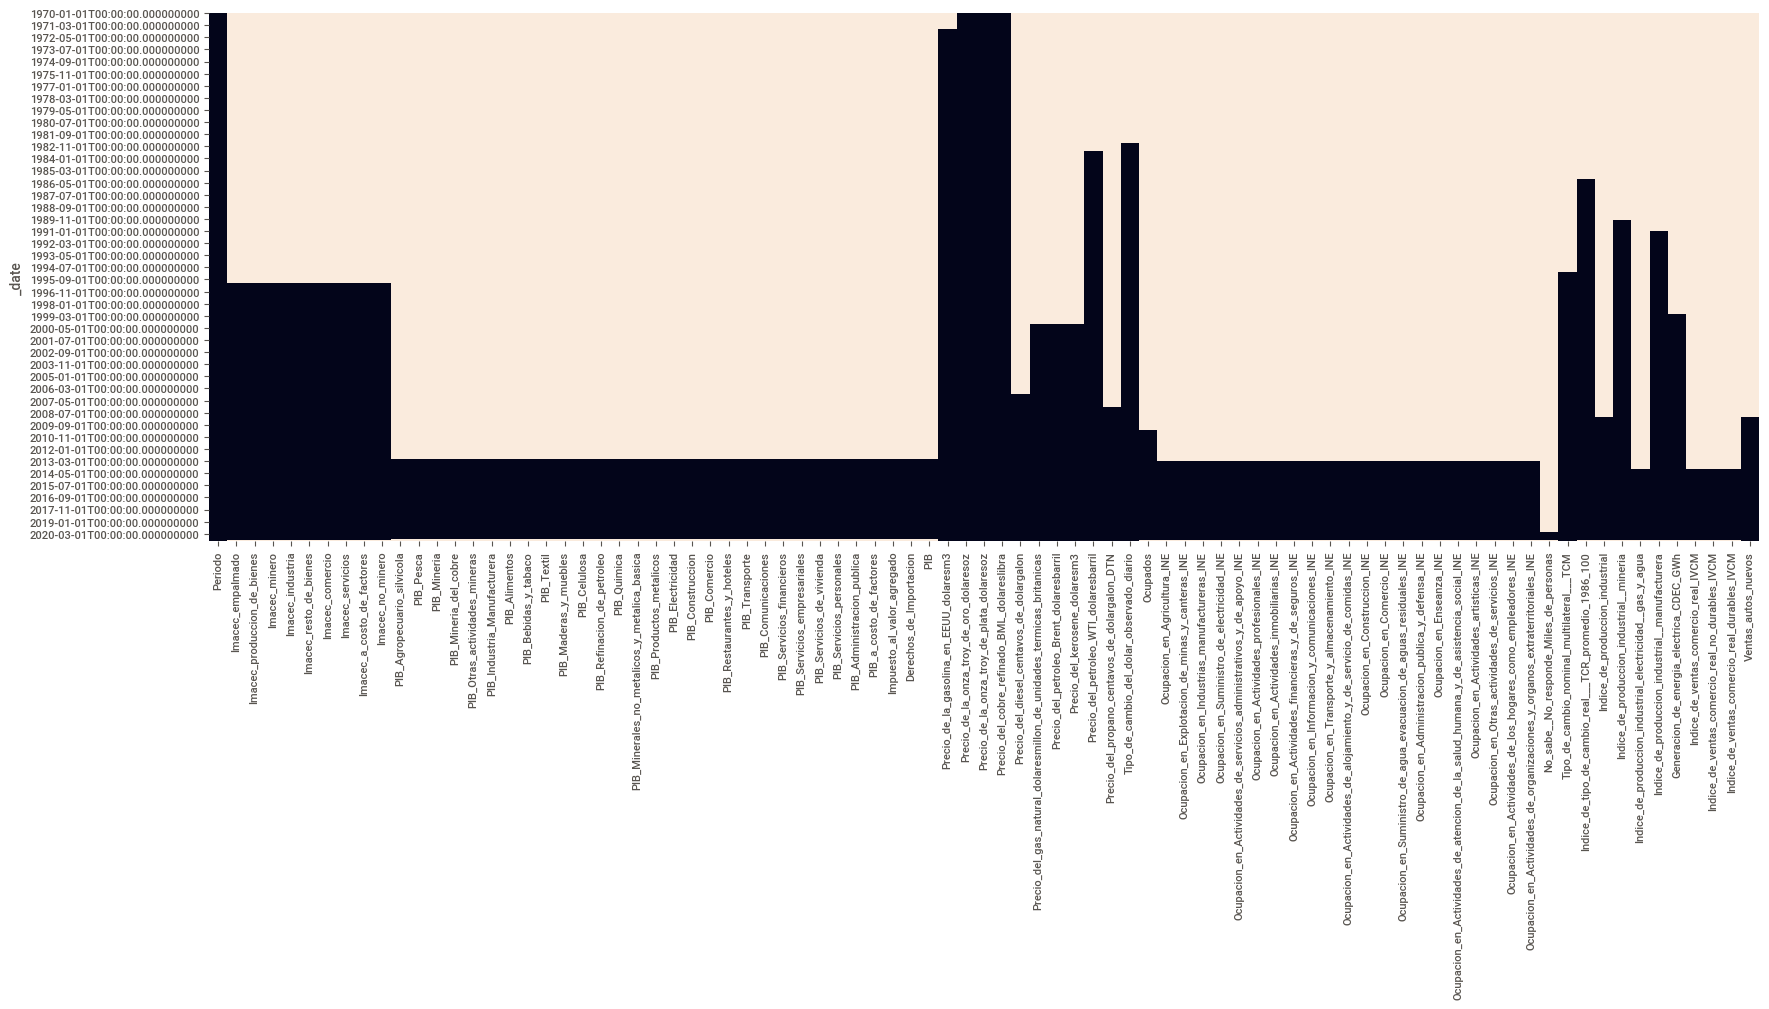

In [14]:
plt.figure(figsize = (20, 7))
sns.heatmap(df_banco_central.isnull(), cbar=False)
plt.show()

4. Los datos del Imacec y PIB fueron interpretados como texto. Así que se revisan los valores para transformarlos en números. Se crea un nuevo reporte `report/banco_central_numeric.html` para visualizar estos datos.

In [15]:
string_columns = [c for c in df_banco_central.select_dtypes('object').columns]
string_columns.remove('Periodo')
df_banco_central[string_columns] = df_banco_central[string_columns].apply(lambda x: x.str.replace('.', '', regex=False).astype(float), axis=1)

In [16]:
reporte_banco_2 = sv.analyze(df_banco_central)
reporte_banco_2.show_html("report/banco_central_numeric.html")

                                             |          | [  0%]   00:00 -> (? left)

Report report/banco_central_numeric.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


En este nuevo reporte se ve que las variables númericas PIB, Imacec y ocupación tienen valores en rangos muy grandes, desde valores bajo el millón hasta billones, por lo que habrá que revisar si puede ser una típica tendencia al alza u otro problema. Nos concentraremos en el PIB y el IMACEC que apriori podrían ser más relevantes para nuestro problema al estar separados por sectores y poder revisar los asociados a la leche.
1. Primero se analiza Imacec, desde la página del banco central se puede rescatar que típicamente su valr fluctua entre 70 y 130, lo que no se corresponde con los valores de millones que vemos. Por eso se va a situar el separador decimal dónde corresponde.

In [17]:
def fix_imacec(raw_imacec: float) -> float:
    """
    Toma un imacec y estima dónde debería ir el decimal
    """
    if str(raw_imacec)=='nan':
        return np.nan
    if float(str(raw_imacec)[0:3]) < 150:
        return float(str(raw_imacec)[0:3])
    else:
        return float(str(raw_imacec)[0:2])

In [18]:
imacec_columns = [c for c in df_banco_central.columns if c.startswith('Imacec_')]
for i in imacec_columns:
    df_banco_central[i] = df_banco_central[i].apply(fix_imacec)

2. de los distintos sectores del imacec se tiene que la mayoría tiene una clara tendencia al alza. Excepto por el sector minero que pareciera mostrar un estancamiento.

<AxesSubplot:xlabel='_date'>

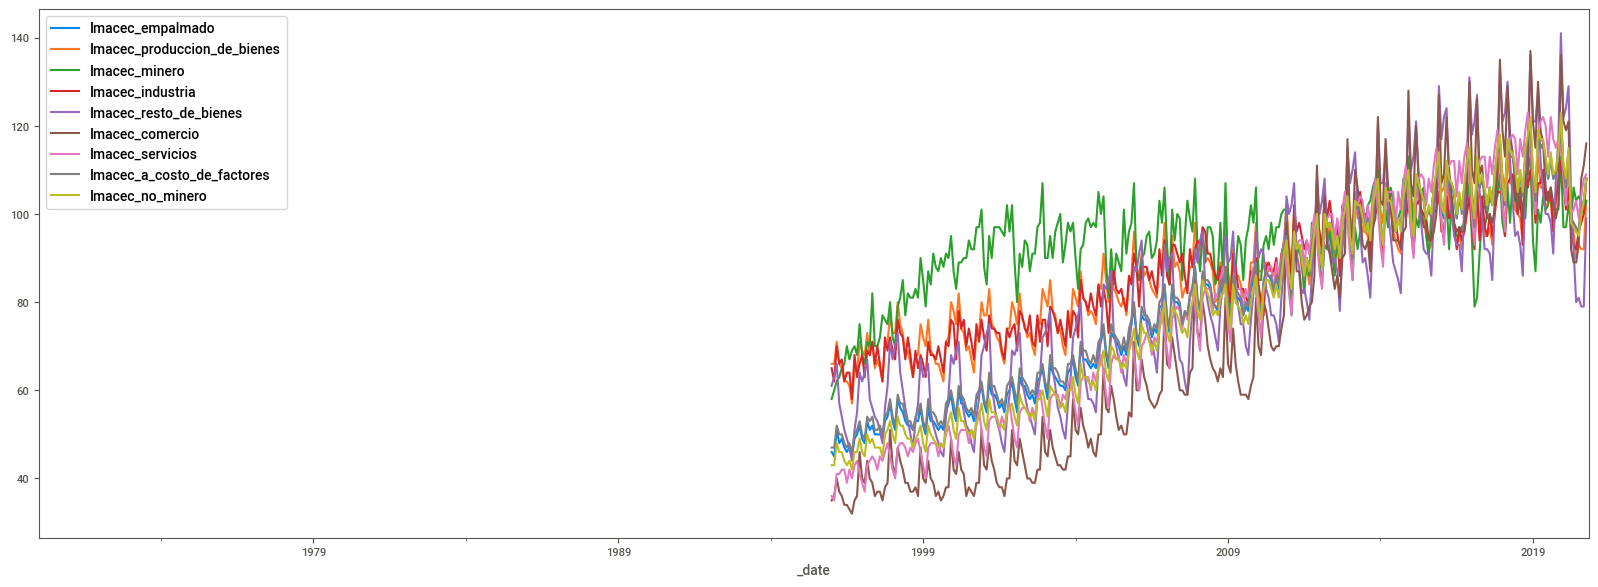

In [19]:
df_banco_central[imacec_columns].plot(figsize = (20, 7))

Las variables de PIB se van a tomar más adelante.

## 3. Visualización
Primero, se analizan las precipitaciones en un periodo de tiempo dado para algunas regiones del país.

In [20]:
def graficar_precipitaciones_region(region: str, inicio: str, fin: str):
    """
    Función que acepta el nombre de una región junto con una fecha de inicio y fin
    en formato YYYY-MM-DD para graficar la serie
    """
    df = df_precipitaciones.copy()
    if not inicio in df.index or not fin in df.index:
        raise ValueError("Una de las fechas utilizadas no existe en los datos o no tiene el formato correcto.")
    elif not region in df.columns:
        raise ValueError("La region ingresada no corresponde a un nombre de las regiones de la base.")
    else:
        df = df.loc[inicio:fin]
        fig = px.line(x=df.index,
                      y=df[region])
        fig.update_layout(
            title=f'Precipitaciones en la region {region} entre {inicio} y {fin}.',
            xaxis_title="Fecha",
            yaxis_title="Precipitaciones [mm]"
        )
        fig.show()

In [21]:
graficar_precipitaciones_region('Libertador_Gral__Bernardo_O_Higgins', '2000-01-01', '2020-01-01')

In [22]:
graficar_precipitaciones_region('Metropolitana_de_Santiago', '2000-01-01', '2020-01-01')

Observando las 2 series anteriores, se refuerza el aprendizaje del análisis de correlaciones, estas 2 regiones cercanas tienen prácticamente el mismo comportamiento, reflejado en su coefiente de correlación de 0.98.

También, se puede apreciar que han decrecido fuertemente los peaks máximos de precipitaciones, mientras al inicio de los 2000 hubo peaks en torno a los 500 y 600 milímetros, desde el 2015 ninguna de las 2 regiones ha supera los 250 milímetros en un mes.

Asimismo, se aprecia la estacionalidad propia de las precipitaciones, cuyos valores más altos se estan entre los meses de mayo y julio, mientras los menores entre diciembre y febrero.

Ahora, se comparan las precipitaciones anuales de una misma región:

In [23]:
def graficar_precipitaciones_anios(region: str, anios: list):
    """
    Función que acepta el nombre de una región junto con una lista de años 
    para graficar una serie por cada uno de los años solicitados
    """
    df = df_precipitaciones.copy()
    if not set(anios).issubset(df.index.year):
        raise ValueError("Alguno de los años ingresados no está en los datos.")
    elif not region in df.columns:
        raise ValueError("La region ingresada no corresponde a un nombre de las regiones de la base.")
    else:
        df = df[df.index.year.isin(anios)]
        fig = px.line(x=df.index.month_name(),
                      y=df[region],
                      color=df.index.year
                     )
        fig.update_layout(
            title=f'Precipitaciones en la region {region} por año.',
            xaxis_title="Mes",
            yaxis_title="Precipitaciones [mm]"
        )
        fig.show()

In [24]:
graficar_precipitaciones_anios('Maule', [1982, 1992, 2002, 2012, 2019])

In [25]:
graficar_precipitaciones_anios('Metropolitana_de_Santiago', [1982, 1992, 2002, 2012, 2019])

Al observar las precipitaciones anuales de la región del Maule, se ve una época de lluvias más prologanda que las vistas para la región Metropoliatna y la región de Ohiggins, que en años como 1982 y 2002 se extiende desde mayo a septiembre. Pero, la estacionnalidad del verano sin lluvias se mantiene.

Por otra parte, acá se ve claramente que las precipitaciones de Junio de 1982 en la región Metropolitana fueron particularmente altas para la región. Pero, que en la región del Maule a pesar de ser igual de alta la cantidad de lluvia, esta precipitacion de cerca de 500 mm se repite los años 1992 y 2002 en diferentes meses.

Por útlimo, algo obvio para un chileno, se ve que mes a mes las precipitaciones en la región del Maule son mayores a las que vemos en la región Metropolitana o la de Ohiggins.

Ahora, se revisan algunas series del PIB:

In [26]:
def graficar_series_pib(series: list, inicio: str, fin: str):
    """
    Función que acepta el nombre de una serie del pib junto con una fecha de inicio y fin
    en formato YYYY-MM-DD para ser graficada
    """
    df = df_banco_central.copy()
    if not inicio in df.index or not inicio in df.index:
        raise ValueError("Una de las fechas utilizadas no existe en los datos o no tiene el formato correcto.")
    elif not set(series).issubset(df.columns):
        raise ValueError("Alguna de las series ingresadas no corresponde no existe en la base.")
    else:
        df = df.loc[inicio:fin][series]
        df = pd.melt(df.reset_index(), id_vars=['_date'])
        fig = px.line(df,
                      x='_date',
                      y='value',
                      color='variable'
                     )
        fig.update_layout(
            title=f'Series {", ".join(series)} entre {inicio} y {fin}.',
            xaxis_title="Fecha",
            yaxis_title="PIB"
        )
        fig.show()

In [27]:
graficar_series_pib(['PIB_Agropecuario_silvicola', 'PIB_Servicios_financieros'], '2013-01-01', '2020-01-01')

De las series del PIB agropecuario y silvicola, se aprecia rápidamente que tiene un peak durante febrero, que desde el 2013 rondea los 600M, excepto en el 2015 dónde febero se desploma hasta los 65M, este caso raro hace notar que las series de PIB tienen un problema similar al del Imacec, ya que hay muchos valores que están en una magnitud menor y no respetan las tendencias de estos indicadores. Por eso se resolverá con las variones entre un periodo y otro.

In [28]:
def fix_pib(pib: pd.Series) -> pd.Series:
    """
    Esta funnción recorre los valores de una serie, lo compara con el valor anterior y el siguiente,
    si es menor que los 2 comprueba si tienen diferencias en magnitud y corrige multiplicando por 10
    """
    sr = pib.copy()
    for i in np.arange(0, len(sr)):
        # Corroboramos si valor anterior, actual y siguiente son no nulos
        if (str(sr[i])!='nan') and ((str(sr[i-1])!='nan')) and ((str(sr[i+1])!='nan')):
            # Corroboramos si el valor actual es menor que los otros
            if (sr[i]<sr[i-1]) & (sr[i]<sr[i+1]):
                # Vemos que sea de una magnitud menor que el siguiente valor
                if (sr[i]/sr[i+1])<0.2:
                    sr[i]=sr[i]*10
    return sr

In [29]:
pib_columns = [c for c in df_banco_central.columns if c.startswith('PIB')]
for i in pib_columns:
    # Apliacmos el cambio más de una vez por casos extraños en que 2 datos consecutivos están con error en la magnitud
    df_banco_central[i] = fix_pib(df_banco_central[i])
    df_banco_central[i] = fix_pib(df_banco_central[i])
    df_banco_central[i] = fix_pib(df_banco_central[i])

In [30]:
graficar_series_pib(['PIB_Agropecuario_silvicola', 'PIB_Servicios_financieros'], '2013-01-01', '2022-01-01')

Ahora con las series del pib corregidas, se ve de forma más clara que la seria del pib agropecuario tiene estacionalidad, creciendo fuertemente en el primer trimestre del año (enero, febrero y marzo) y sus valores más bajos lo alcanza en el tercer trimestre (julio, agosto, septiembre). También, no se observa en esta serie que haya una tendencia de crecimiento o decrecimiento en el tiempo.

Por el lado de del PIB de servicios financieros, si muestra una tendencia al alza desde los 500M a 600M que tenía durante el 2013 a estableccerse sobre los 700M durate el 2020.

## 4. Tratamiento y creación de variables
En los siguientes puntos se trata de pedecir el precio de la leche usando las precipitaciones y variables económicas. Es deseable, que las variables que vamos a utilizar tengan algún tipo de correlación con nuestra variable a predecir (el precio de la leche), independiente de que esta correlación sea positiva o negativa, mientras mayor sea el módulo de esas correlaciones mayor será la información que nos entrega la variable para predecir el precio de la leche.

Por otro lado, dependiendo del tipo de modelo que se utilice para la predicción del precio de la leche, puede ser necesario que las variables predictoras que utilicemos no estén muy correlacionadas entre sí, debido a que entregan la misma información y en modelos como la regresión lineal no exista solución al momento de tratar de invertir la matriz de variables independientes.

Dado que estas series son de valores numéricos, podemos utilizar algún coeficiente de correlación, el más típico es el de Pearson.

Ahora, se unen las bases y se crean nuevas variables.

In [31]:
df_precio_leche = pd.read_csv("data/precio_leche.csv")
df_precio_leche.head()

Anio  Mes  Precio_leche
0  1979  Ene          3.85
1  1979  Feb          4.58
2  1979  Mar          5.18
3  1979  Abr          6.06
4  1979  May          7.25

In [32]:
reporte_precio_leche = sv.analyze(df_precio_leche)
reporte_precio_leche.show_html("report/precio_leche.html")

                                             |          | [  0%]   00:00 -> (? left)

Report report/precio_leche.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


En los datos del precio de la leche no hay una fecha creada, lo más complicado es que el mes está con su abreviatura en español, se crea la nueva variable y se une con los otros datasets:

In [33]:
def get_month_number(month_name: str) -> int:
    """
    Función para obtnener número del mes del año desde su abeviación en español
    """
    months = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep','Oct', 'Nov', 'Dic']
    return months.index(month_name)+1

df_precio_leche['month'] = df_precio_leche['Mes'].apply(get_month_number).astype(str)
df_precio_leche['date_dt'] = pd.to_datetime(dict(year=df_precio_leche['Anio'], month=df_precio_leche['month'], day='1'))
df_precio_leche = set_datetime_index(df_precio_leche, 'date_dt')
df_precio_leche.head()

Anio  Mes  Precio_leche month    date_dt
_date                                               
1979-01-01  1979  Ene          3.85     1 1979-01-01
1979-02-01  1979  Feb          4.58     2 1979-02-01
1979-03-01  1979  Mar          5.18     3 1979-03-01
1979-04-01  1979  Abr          6.06     4 1979-04-01
1979-05-01  1979  May          7.25     5 1979-05-01

Se corrobora que no hay periodos duplicados!

In [34]:
df_precio_leche.groupby('_date').size().sort_values(ascending=False)[0:3]

_date
1979-01-01    1
2006-09-01    1
2007-10-01    1
dtype: int64

Se unen los datasets, además de corroborar que desde 1979 no queda ningún valor nulo del precio de la leche:

In [35]:
df_model = pd.concat([df_precio_leche, df_precipitaciones, df_banco_central], axis=1)
print("Cantidad de datos nulos del precio de la leche:",
      df_model['Precio_leche'].loc['1979':].isna().sum())
df_model.loc['1979':].head()

Cantidad de datos nulos del precio de la leche: 0


Anio  Mes  Precio_leche month    date_dt        date   Coquimbo  \
_date                                                                           
1979-01-01  1979.0  Ene          3.85     1 1979-01-01  1979-01-01   2.641948   
1979-02-01  1979.0  Feb          4.58     2 1979-02-01  1979-02-01   1.179804   
1979-03-01  1979.0  Mar          5.18     3 1979-03-01  1979-03-01   0.255490   
1979-04-01  1979.0  Abr          6.06     4 1979-04-01  1979-04-01  10.173699   
1979-05-01  1979.0  May          7.25     5 1979-05-01  1979-05-01   1.039098   

            Valparaiso  Metropolitana_de_Santiago  \
_date                                               
1979-01-01    0.587062                   2.447114   
1979-02-01    2.432192                   3.997852   
1979-03-01    0.020601                   0.000000   
1979-04-01   11.745779                  13.722349   
1979-05-01   18.609286                  50.187148   

            Libertador_Gral__Bernardo_O_Higgins  ...  \
_date                                            ...   
1979-01-01                             1.608992  ...   
1979-02-01                             4.346310  ...   
1979-03-01                             0.055488  ...   
1979-04-01                            12.989194  ...   
1979-05-01                           104.451550  ...   

            Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100  \
_date                                                               
1979-01-01                                                NaN       
1979-02-01                                                NaN       
1979-03-01                                                NaN       
1979-04-01                                                NaN       
1979-05-01                                                NaN       

            Indice_de_produccion_industrial  \
_date                                         
1979-01-01                              NaN   
1979-02-01                              NaN   
1979-03-01                              NaN   
1979-04-01                              NaN   
1979-05-01                              NaN   

            Indice_de_produccion_industrial__mineria  \
_date                                                  
1979-01-01                                       NaN   
1979-02-01                                       NaN   
1979-03-01                                       NaN   
1979-04-01                                       NaN   
1979-05-01                                       NaN   

            Indice_de_produccion_industrial_electricidad__gas_y_agua  \
_date                                                                  
1979-01-01                                                NaN          
1979-02-01                                                NaN          
1979-03-01                                                NaN          
1979-04-01                                                NaN          
1979-05-01                                                NaN          

           Indice_de_produccion_industrial__manufacturera  \
_date                                                       
1979-01-01                                            NaN   
1979-02-01                                            NaN   
1979-03-01                                            NaN   
1979-04-01                                            NaN   
1979-05-01                                            NaN   

            Generacion_de_energia_electrica_CDEC_GWh  \
_date                                                  
1979-01-01                                       NaN   
1979-02-01                                       NaN   
1979-03-01                                       NaN   
1979-04-01                                       NaN   
1979-05-01                                       NaN   

            Indice_de_ventas_comercio_real_IVCM  \
_date                                             
1979-01-01                                  Na

Debido a la gran cantidad de variables disponibles, se usa un filtro por coeficiente de correlación para escoger las variables que ayudarán a predecir el precio de la leche. Sólo se calcula este coeficiente a partir del año 2013 para tener disponible el PIB e Imacec.

In [36]:
n = 30
print(f"{n} variables más correlacionadas con el precio de la leche:")
df_model.loc['2013':].corr()['Precio_leche'].abs().sort_values(ascending=False)[0:n]

30 variables más correlacionadas con el precio de la leche:


Precio_leche                                                                          1.000000
Anio                                                                                  0.729312
Precio_de_la_onza_troy_de_oro_dolaresoz                                               0.705436
PIB_Servicios_financieros                                                             0.658721
Generacion_de_energia_electrica_CDEC_GWh                                              0.563089
PIB_Textil                                                                            0.558394
PIB_Restaurantes_y_hoteles                                                            0.545453
Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100                                 0.446130
PIB_Bebidas_y_tabaco                                                                  0.412980
Precio_del_gas_natural_dolaresmillon_de_unidades_termicas_britanicas                  0.359949
Ocupacion_en_Actividades_de_los_hogares_como_emple

Nos ayudamos de graficar las distintas series para ver cómo se relacionan:

In [37]:
def graficar_series(series: list, inicio: str, fin: str):
    """
    Función que acepta el nombre de series de nuestro dataframe junto con una fecha de inicio y fin
    en formato YYYY-MM-DD para ser graficada
    """
    df = df_model.copy()
    if not inicio in df.index or not inicio in df.index:
        raise ValueError("Una de las fechas utilizadas no existe en los datos o no tiene el formato correcto.")
    elif not set(series).issubset(df.columns):
        raise ValueError("Alguna de las series ingresadas no corresponde no existe en la base.")
    else:
        df = df.loc[inicio:fin][series]
        # Cada serie es dividida por su valor promedio para homologar escalas
        for i in series: 
            df[i] = df[i]/df[i].mean()
        df = pd.melt(df.reset_index(), id_vars=['_date'])
        fig = px.line(df,
                      x='_date',
                      y='value',
                      color='variable'
                     )
        fig.update_layout(
            title=f'Series entre {inicio} y {fin}.',
            xaxis_title="Fecha",
            yaxis_title="Valor"
        )
        fig.show()

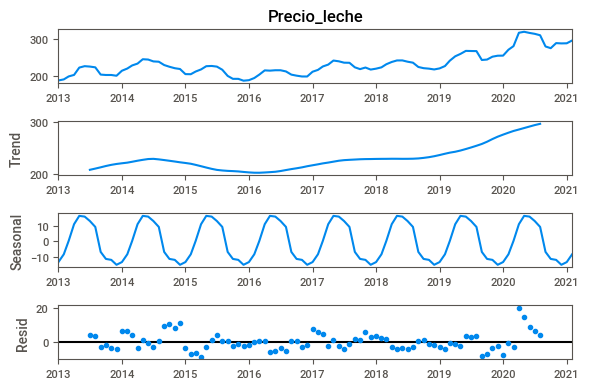

In [38]:
# Se utiliza un método de descomposición para separar la serie en tendencia y estacionalidad.
decomposition = sm.tsa.seasonal_decompose(df_model['Precio_leche'].loc['2013':], model='additive')
fig = decomposition.plot()
plt.show()

In [39]:
graficar_series(['Precio_leche'], '2013-01-01', '2021-01-01')

In [40]:
graficar_series(['Precio_leche', 'PIB_Servicios_financieros', 'PIB_Agropecuario_silvicola', 'Precio_de_la_onza_troy_de_oro_dolaresoz', 'Los_Rios'], '2013-01-01', '2021-01-01')

De los gráficos se verifica que el precio de la leche sigue una tendencia al alza similar a las series del PIB de servicios financieros y el precio de la onza troy de oro.

Además, del gráfico de descomposición del precio de la leche se nota una clara estacionalidad, esta se producce con un peak entre el segundo y tercer trimestre del año (de abril a julio) y alcanza sus valores minimos en el cuarto trimestre del año. Este ciclo no se condice con la estacionalidad del PIB agropecuario lo que explica que su correlación sea bastate menor que la que tiene con el PIB de servicios financieros.

Por otro lado, la estacionalidad con un peak en invierno del precio de la leche se correlaciona bastante con el movimiento de las precipitaciones de nuestro país, siendo la de mayor correlación la de la región de Los Ríos. 

Finalmente, entendiendo las asociaciones anteriores, sumado a la características autorregresivas de las series de tiempo y las tendencias y estacionalidades analizadas, se pasa a la construcción de variables.

In [41]:
# Variables derivadas de la fecha
covar_fechas = ['year', 'month', 'quarter']
df_model['year'] = df_model.index.year
df_model['month'] = df_model.index.month
df_model['quarter'] = df_model.index.quarter
df_model[covar_fechas].head()

year  month  quarter
_date                           
1970-01-01  1970      1        1
1970-02-01  1970      2        1
1970-03-01  1970      3        1
1970-04-01  1970      4        2
1970-05-01  1970      5        2

Un punto importate del modelo a construir más adelante es que necesitamos predecir el precio de la leche en el futuro, entonces por ejemplo, cuando se quiera predecir el precio de la leche para mayo de 2021 sólo estarán disponibles las precipitaciones y variables económicas hasta abril de 2021 (asumiendo que el PIB de abril se entregará antes de que comience mayo). Para estructurar este problema como uno de regresión, sólo se construyen variables disponibles un mes antes del precio de la leche que se desea predecir.

In [42]:
# Variables relacionadas a la relación intrínsecas de la serie del pecio de la leche
covar_precio_leche = ['leche_anio_anterior', 'leche_mes_anterior', 'leche_crecimiento_anio',
                     'leche_prom_3_meses']
df_model['leche_anio_anterior'] = df_model['Precio_leche'].shift(12)
df_model['leche_mes_anterior'] = df_model['Precio_leche'].shift(1)
df_model['leche_crecimiento_anio'] = df_model['leche_mes_anterior']/df_model['Precio_leche'].shift(13)
df_model['leche_prom_3_meses'] = df_model['Precio_leche'].shift(1).rolling(3).mean()
df_model[covar_precio_leche].loc['2013':].head()

leche_anio_anterior  leche_mes_anterior  leche_crecimiento_anio  \
_date                                                                         
2013-01-01               184.49              189.89                1.027877   
2013-02-01               190.74              186.63                1.011600   
2013-03-01               195.09              189.52                0.993604   
2013-04-01               199.93              197.60                1.012866   
2013-05-01               202.96              201.70                1.008853   

            leche_prom_3_meses  
_date                           
2013-01-01          189.710000  
2013-02-01          188.576667  
2013-03-01          188.680000  
2013-04-01          191.250000  
2013-05-01          196.273333

In [43]:
# Lag y crecimiennto anual de algunas de las variables más correlacionadas con el precio de la leche.
def create_lag_variable(column: pd.Series) -> pd.Series:
    """
    Toma una serie y calcula el lag de 1 mes
    """
    sr = column.copy()
    return sr.shift(1)
    
def create_one_year_var(column: pd.Series) -> pd.Series:
    """
    Toma una serie y calcula el ratio entre el mes anterior y el mismo mes del año anterior
    """
    sr = column.copy()
    return sr.shift(1)/sr.shift(13)

covar_lags = []
covar_crecimiento_anio = []
for var in ['Precio_de_la_onza_troy_de_oro_dolaresoz', 'PIB_Servicios_financieros', 'PIB_Textil',
            'PIB_Restaurantes_y_hoteles', 'PIB_Bebidas_y_tabaco', 'Los_Rios', 'La_Araucania']:
    new_lag_var = f"{var}_mes_anterior"
    covar_lags.append(new_lag_var)
    df_model[new_lag_var] = create_lag_variable(df_model[var])
    new_crecimiento_anio_var = f"{var}_mes_anterior"
    covar_crecimiento_anio.append(new_crecimiento_anio_var)
    df_model[new_crecimiento_anio_var] = create_one_year_var(df_model[var])

df_model.loc['2014':][covar_lags + covar_crecimiento_anio].head()

Precio_de_la_onza_troy_de_oro_dolaresoz_mes_anterior  \
_date                                                              
2014-01-01                                           0.725611      
2014-02-01                                           0.744382      
2014-03-01                                           0.800672      
2014-04-01                                           0.837619      
2014-05-01                                           0.874642      

            PIB_Servicios_financieros_mes_anterior  PIB_Textil_mes_anterior  \
_date                                                                         
2014-01-01                                     NaN                      NaN   
2014-02-01                                1.055188                 0.873886   
2014-03-01                                1.050937                 0.830842   
2014-04-01                                1.046752                 0.882325   
2014-05-01                                1.038975                 0.822117   

            PIB_Restaurantes_y_hoteles_mes_anterior  \
_date                                                 
2014-01-01                                      NaN   
2014-02-01                                 1.052459   
2014-03-01                                 1.049633   
2014-04-01                                 1.041544   
2014-05-01                                 1.042232   

            PIB_Bebidas_y_tabaco_mes_anterior  Los_Rios_mes_anterior  \
_date                                                                  
2014-01-01                                NaN               0.103075   
2014-02-01                           0.935454               3.575394   
2014-03-01                           0.915166               0.403237   
2014-04-01                           0.962437               2.348802   
2014-05-01                           0.889567               0.836751   

            La_Araucania_mes_anterior  \
_date                                   
2014-01-01                   0.052882   
2014-02-01                   4.543113   
2014-03-01                   0.510307   
2014-04-01                   3.510591   
2014-05-01                   1.138086   

            Precio_de_la_onza_troy_de_oro_dolaresoz_mes_anterior  \
_date                                                              
2014-01-01                                           0.725611      
2014-02-01                                           0.744382      
2014-03-01                                           0.800672      
2014-04-01                                           0.837619      
2014-05-01                                           0.874642      

            PIB_Servicios_financieros_mes_anterior  PIB_Textil_mes_anterior  \
_date                                                                         
2014-01-01                                     NaN                      NaN   
2014-02-01                                1.055188                 0.873886   
2014-03-01                                1.050937                 0.830842   
2014-04-01                                1.046752                 0.882325   
2014-05-01                                1.038975                 0.822117   

            PIB_Restaurantes_y_hoteles_mes_anterior  \
_date                                                 
2014-01-01                                      NaN   
2014-02-01                                 1.052459   
2014-03-01                                 1.049633   
2014-04-01                                 1.041544   
2014-05-01                                 1.042232   

            PIB_Bebidas_y_tabaco_mes_anterior  Los_Rios_mes_anterior  \
_date                                                                  
2014-01-01                                NaN               0.103075   
2014-02-01                           0.935454               3.575394   
2014-03-01                           0.915166               0.403237   
2014-04-01               

In [44]:
df_model.sort_values('_date', axis='index', ascending=False)

Anio  Mes  Precio_leche  month    date_dt date  Coquimbo  \
_date                                                                    
2021-02-01  2021.0  Feb        295.24      2 2021-02-01  NaN       NaN   
2021-01-01  2021.0  Ene        287.60      1 2021-01-01  NaN       NaN   
2020-12-01  2020.0  Dic        287.29     12 2020-12-01  NaN       NaN   
2020-11-01  2020.0  Nov        288.09     11 2020-11-01  NaN       NaN   
2020-10-01  2020.0  Oct        274.32     10 2020-10-01  NaN       NaN   
...            ...  ...           ...    ...        ...  ...       ...   
1970-05-01     NaN  NaN           NaN      5        NaT  NaN       NaN   
1970-04-01     NaN  NaN           NaN      4        NaT  NaN       NaN   
1970-03-01     NaN  NaN           NaN      3        NaT  NaN       NaN   
1970-02-01     NaN  NaN           NaN      2        NaT  NaN       NaN   
1970-01-01     NaN  NaN           NaN      1        NaT  NaN       NaN   

            Valparaiso  Metropolitana_de_Santiago  \
_date                                               
2021-02-01         NaN                        NaN   
2021-01-01         NaN                        NaN   
2020-12-01         NaN                        NaN   
2020-11-01         NaN                        NaN   
2020-10-01         NaN                        NaN   
...                ...                        ...   
1970-05-01         NaN                        NaN   
1970-04-01         NaN                        NaN   
1970-03-01         NaN                        NaN   
1970-02-01         NaN                        NaN   
1970-01-01         NaN                        NaN   

            Libertador_Gral__Bernardo_O_Higgins  ...  leche_mes_anterior  \
_date                                            ...                       
2021-02-01                                  NaN  ...              287.60   
2021-01-01                                  NaN  ...              287.29   
2020-12-01                                  NaN  ...              288.09   
2020-11-01                                  NaN  ...              274.32   
2020-10-01                                  NaN  ...              278.99   
...                                         ...  ...                 ...   
1970-05-01                                  NaN  ...                 NaN   
1970-04-01                                  NaN  ...                 NaN   
1970-03-01                                  NaN  ...                 NaN   
1970-02-01                                  NaN  ...                 NaN   
1970-01-01                                  NaN  ...                 NaN   

            leche_crecimiento_anio  leche_prom_3_meses  \
_date                                                    
2021-02-01                1.131838          287.660000   
2021-01-01                1.131687          283.233333   
2020-12-01                1.146764          280.466667   
2020-11-01                1.126849          287.583333   
2020-10-01                1.151757          300.576667   
...                            ...                 ...   
1970-05-01                     NaN                 NaN   
1970-04-01                     NaN                 NaN   
1970-03-01                     NaN                 NaN   
1970-02-01                     NaN                 NaN   
1970-01-01                     NaN                 NaN   

            Precio_de_la_onza_troy_de_oro_dolaresoz_mes_anterior  \
_date                                                              
2021-02-01                                                NaN      
2021-01-01                                                NaN      
2020-12-01                                           1.269445      
2020-11-01                                           1.271178      
2020-10-01                                           1.275473      
...                                                       ...      
1970-05-01                                                NaN      
1970-

## 5. Modelo
Pasamos a construir un modelo que permita predecir el valor del precio de la leche en el siguiente mes. Lo primero es generar una base de entrenamiento y una de test. La definicición será que sólo se usará para ambas bases datos a partir de febrero de 2014, ya que desde ahí están bien definidas las variables de lag y variación anual que se crearon. Cabe señalar que para el entrenamiento se utilizará validación cruzada temporal para lograr verificar la capacidad de generalización de nuestro modelo sólo siendo entrenado con información del pasado.

Para la base de test, se deja el último año en que tenemos todas las variables definidas (mayo de 2019 hasta abril de 2020). Se deja una base de test temporalmente posterior para poder validar la capacidad de extrapolación del modelo en un año sin datos, tomando en cuenta la tendencia al alza del precio de la leche. Además, con un año completo se alcanza a testear el modelo en todos los meses del año, debido a la estacionalidad de la serie.

Con esto, se deja una proporión de 84% de la base para entrenamiento y un 16% para test.

In [45]:
df_train = df_model['2014-02-01':'2019-04-01']
print("Dimensión de la base de entrenamiento:", df_train.shape)
df_test = df_model['2019-05-01':'2020-04-01']
print("Dimensión de la base de testeo:", df_test.shape)

Dimensión de la base de entrenamiento: (63, 112)
Dimensión de la base de testeo: (12, 112)


El primer intento será con una regresión lineal (a pesar de que puede que se viole la hipótesis de autocorrelación), pero servirá para revisar rápidamente variables con un buen poder predictivo.

Del modelo llaman inmediatamente la atención las variables crecimiento anual del precio de la leche y su valor del mes anterior, siendo las más significativas. Por ello, a continuación se compara la performance del modelo contra una predicción simple: escoger el mismo valor del mes anterior. Esto permitirá entender si el modelo es mejor que este recurso simple.

Dado que estamos comparando series de tiempo, tiene sentido usar métricas de ajuste de variables numéricas como MAE, MAPE, RMSE y otros. Asumiendo que importa mucho el no tener valores muy alejados en nuestra predicción se utilizará el RMSE, ya que al elevar al cuadrado la distancia entre el valor predicho y el real, penaliza con más fuerza los errores grandes en comparación al MAE, por ejemplo.

In [46]:
covars = covar_fechas + covar_lags + covar_crecimiento_anio + covar_precio_leche
mod = sm.OLS(df_train['Precio_leche'], df_train[covars]).fit()
print(mod.summary())

                                 OLS Regression Results                                
Dep. Variable:           Precio_leche   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                              8883.
Date:                Tue, 03 Aug 2021   Prob (F-statistic):                    2.54e-78
Time:                        22:07:52   Log-Likelihood:                         -182.40
No. Observations:                  63   AIC:                                      392.8
Df Residuals:                      49   BIC:                                      422.8
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                                                           coef    std err          t      P>|t|      [0.025      0.975]

In [47]:
# Se generan las distintas prediciones y se comparan con RMSE y gráficamente
df_total = pd.concat([df_train, df_test])
predicciones = pd.DataFrame({'fecha': df_total.index,
                             'regresion_lineal': mod.predict(df_total[covars]),
                             'mes_anterior': df_total['leche_mes_anterior'],
                             'real': df_total['Precio_leche']
                            })

def compare_rmse(preds: list):
    for p in preds:
        print(f"El RMSE en el test set para {p} es: {mean_squared_error(predicciones['2019-05-01':]['real'], predicciones['2019-05-01':][p], squared=False)}")

compare_rmse(['regresion_lineal', 'mes_anterior'])

# Graficamos las distintas predicciones
def graficar_predicciones(pred: pd.DataFrame):
    """
    Compara gráficamente las distintas pedicciones realizadas
    """
    df_plot = pd.melt(predicciones, id_vars=['fecha'])
    fig = px.line(df_plot, x='fecha', y='value', color='variable')
    # añadir fondo de otro color para mostrar prediccciones
    fig.add_vrect(x0='2019-05-01', x1='2020-04-01', fillcolor="grey", opacity=0.15)
    fig.show()

graficar_predicciones(predicciones)

El RMSE en el test set para regresion_lineal es: 13.526241426927083
El RMSE en el test set para mes_anterior es: 14.24920494858105


Lamentablemente, el primer intento con regresión lineal no tiene un desempeño en términos de RMSE mucho mayor que simplemente predecir que se repetirá el precio de la leche del mes actual.

Para tratar de mejorar la predicción se probará de forma batante ingenua con otros algoritmos de regresión que suelen tener menor sesgo que la regresión lineal para corroborar si conseguimos alguna mejora. En este caso utilizaré validación cruzada con separación temporal para poder escoger el modelo que generalice de mejor forma en este problema utilizando como métrica el RMSE.

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit

rs = 12

models_to_train = {
    'lr': LinearRegression(),
    'gbr': GradientBoostingRegressor(random_state=rs),
    'rf': RandomForestRegressor(random_state=rs)
}

cv_scores = {}
for k, model in models_to_train.items():
    print(f"--- CV on {k} ---")
    _cv_scores = cross_validate(
        model,
        df_train[covars],
        df_train['Precio_leche'],
        cv=TimeSeriesSplit(n_splits=10),
        scoring='neg_root_mean_squared_error'
        )
    cv_scores[k] = _cv_scores

--- CV on lr ---
--- CV on gbr ---
--- CV on rf ---


Luego de aplicar la validación cruzada con estos 3 modelos, observamos que el Random Forest es el que obtiene el menor RMSE promedio. Además, este mismo modelo es el que tiene menor desviación estandar como se aprecia en el boxplot, por lo que es el modelo con mejor capacidad de generalización para este problema entre los que probamos y será nuestro candidato dentro del mundo de los algoritmos de regresión.

In [49]:
models_comparison_metrics = pd.DataFrame.from_dict(
    {k: -1*m2 for k, m in cv_scores.items() for k2, m2 in m.items() if k2 == 'test_score'}
)
print('RMSE mean in CV:', '\n', models_comparison_metrics.mean(), '\n')
print('RMSE std in CV:', '\n', models_comparison_metrics.std())


fig = px.box(models_comparison_metrics, title='Cross Validation RMSE').update_yaxes(range=[0, 100], title='RMSE')
fig.show()

RMSE mean in CV: 
 lr     1135.185236
gbr      10.380586
rf        9.340422
dtype: float64 

RMSE std in CV: 
 lr     3552.975821
gbr       6.314921
rf        5.331591
dtype: float64


A continuación, utilizamos una simple búsqueda de grilla aleatoria para encontrar la mejor configuración del Random Forest. Cabe destacar, que se buscará minimizar el RMSE (en negativo) y se utiliza validación cruzada con particiones temporales.

In [50]:
# Se crea la grilla de posibles parametros
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [5, 10, 15]
min_samples_leaf = [1, 5, 10, 15]
bootstrap = [True]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [51]:
%%time
# Se entrena el random forest usando como metrica el Mean Square Error y RandomizedSearchCV
rf = RandomForestRegressor(criterion='mse')
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv = TimeSeriesSplit(n_splits=5),
                               verbose=2,
                               random_state=12, 
                               n_jobs = -1,
                               scoring='neg_root_mean_squared_error'
                              )
rf_random.fit(df_train[covars], df_train['Precio_leche'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.3min finished


CPU times: user 3.49 s, sys: 336 ms, total: 3.83 s
Wall time: 2min 22s


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                   estimator=RandomForestRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 5, 10, 15],
                                        'min_samples_split': [5, 10, 15],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=12, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [52]:
# Se revisa el mejor modelo estimado
print("Parámetros del mejor modelo:", rf_random.best_params_)
print("RMSE en la validación cruzada:", sqrt(-1*rf_random.best_score_))
best_rf = rf_random.best_estimator_

Parámetros del mejor modelo: {'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': True}
RMSE en la validación cruzada: 3.4578732715248193


Se revisa cuáles son las variables más importantes del random forest, verificando que tiene mucha relevancia el precio de la leche en el mes anterior, el promedio de los últimos 3 meses y el crecimiento anual.

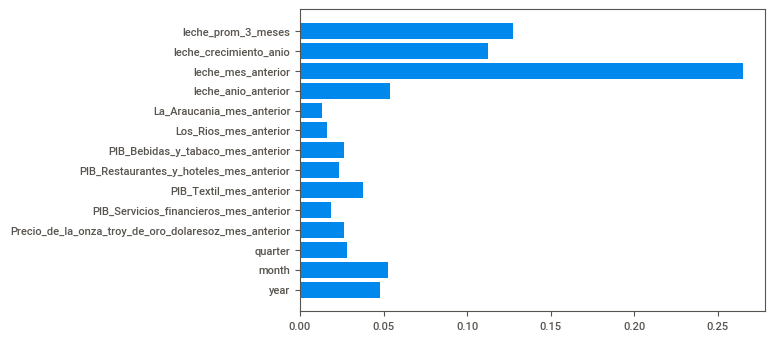

In [53]:
plt.barh(df_total[covars].columns, best_rf.feature_importances_)
plt.show()

Ahora, se comparan los desempeños en la base de test de nuestros modelos:
- Se ve que el modelo de regresión lineal sigue siendo el mejor, quedando como la mejor alternativa presentada para la predicción del precio de la leche, siendo mejor que simplemente predecir que el precio se repetirá.
- El modelo de random forest está muy sobreajustado, en la base de entrenamiento tenía valores de RMSE mucho menores que el obtenido en la base de test. Una hipótesis de esto, es que los modelos basados en árboles suelen tener problemas para extrapolar valores fuera de la muestra original, lo que justamente ocurre en esta serie que hacia el final sube a valores que no se ven anteriormente. Una forma de mitigar este problema sería tratando de predicir la variación temporal de la serie, convirtiéndola en una estacionaria.

In [54]:
predicciones['random_forest'] = best_rf.predict(df_total[covars])
compare_rmse(['regresion_lineal', 'mes_anterior', 'random_forest'])
graficar_predicciones(predicciones)

El RMSE en el test set para regresion_lineal es: 13.526241426927083
El RMSE en el test set para mes_anterior es: 14.24920494858105
El RMSE en el test set para random_forest es: 35.35060621495493


Debido a que el intento de tomar el problema como uno de regresión no obtuvo muy buenos resultados, probaré con el framework para predicción de series de tiempo de Facebook: Prophet.

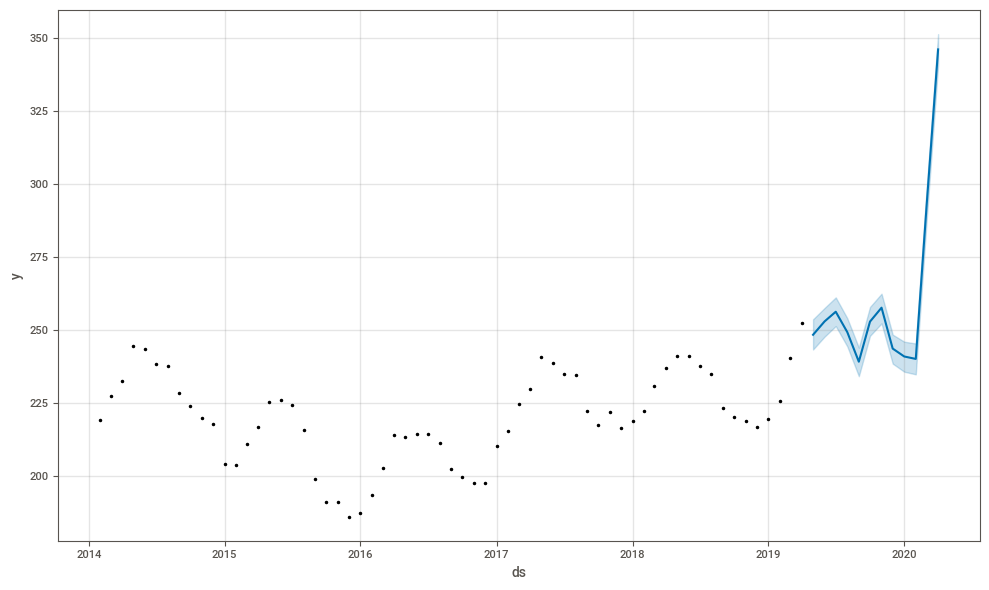

CPU times: user 6.74 s, sys: 624 ms, total: 7.37 s
Wall time: 7.47 s


In [55]:
%%time
from prophet import Prophet

# instanciar modelo
m = Prophet(
    seasonality_mode='additive',
    weekly_seasonality = False,
    daily_seasonality = False
)

# Utilizamos las mismas variables anteriormente seleccionadas, pero esta vez no construimos los lags para que prophet infiera su comportamiento
prophet_vars = ['Precio_de_la_onza_troy_de_oro_dolaresoz', 'PIB_Servicios_financieros',
                'PIB_Textil','PIB_Restaurantes_y_hoteles', 'PIB_Bebidas_y_tabaco',
                'Los_Rios', 'La_Araucania', 'Precio_leche']

# Formatear variables para prophet

x_train = df_train[prophet_vars].copy()
x_train['ds'] = df_train.index
x_train.rename(columns={'Precio_leche': 'y'}, inplace=True)

x_test = df_test[prophet_vars].copy()
x_test['ds'] = df_test.index
x_test.rename(columns={'Precio_leche': 'y'}, inplace=True)

x_total = df_total[prophet_vars].copy()
x_total['ds'] = df_total.index
x_total.rename(columns={'Precio_leche': 'y'}, inplace=True)

for regressor in [r for r in prophet_vars if r != 'Precio_leche']:
    m.add_regressor(regressor)
    
m.fit(x_train)
forecast_test = m.predict(x_test)
forecast_total = m.predict(x_total)

m.plot(forecast_test)
plt.show()

In [56]:
predicciones['prophet'] = forecast_total['yhat'].to_list()
compare_rmse(['regresion_lineal', 'mes_anterior', 'random_forest', 'prophet'])
graficar_predicciones(predicciones)

El RMSE en el test set para regresion_lineal es: 13.526241426927083
El RMSE en el test set para mes_anterior es: 14.24920494858105
El RMSE en el test set para random_forest es: 35.35060621495493
El RMSE en el test set para prophet es: 16.029811736314638


Con esto se deduce que la regresión lineal tiene un poder de predicción levemente superior a simplemente predecir que el precio del próximo mes de la leche será igual al actual. Aunque, aún quedan muchos caminos para poder obtener una mejor predicción:

- Primero, debido a que esta es una prueba de tiempo reducido, faltó analizar el resto de variables disponibles (precios de la onza de oro, ocupación en el país, ocupaciones por sector, etc) para entender mejor su relación directa o mediante interacciones con el precio de la leche.
- A pesar de tener un RMSE más bajo quesólo utilizar el mes anterior, el modelo de Prophet fue el único capaz de intuir una fuerte alza en el precio de la leche en Abril del 2020, ni Random Forest ni la regresión lineal lo lograron. Pero, el error en la predicción en valores intermedio fue más grande para este modelo.
- En la misma línea, es esperable que el modelo de Random forest o el del framework Prophet tengan mejores rendimientos si se toma más tiempo para ajustar sus hiperparámetros o convertir el problema en uno estacionario.  
- Segundo, sería interesante contar con algunas variables que puedan expresar de mejor manera la oferta y demanda de leche. Por ejemplo, la cantidad de litros vendidos durante los años o la capacidad de producción de las lecheras del país.
- También, debido a que se trata de predecir precio de un producto, sería útil tener el movimiento de precio de productos complementarios y sustitutos.
- Otras variables interesantes serían relacionadas a distintos factores ambientales que afecten la producción de leche, por ejemplo, disposición de agua o alimento para las vacas.

Con respecto a los usos, se puede pensar que un modelo de este estilo tendría varios usos para empresas que estén en el rubro de la venta o compra de leche. Por ejemplo, un productor podría planificar capacidad de produccción de forma más eficiente al poder estimar sus ingresos esperados, o desde el punto de vista de algún comprador, planificar la acumulación de compras en periodos dónde se espera que el precio sea menor.

Para terminar, relacionando este problema y el del cambio climático, es conocido que la industria ganadera es una de las grandes emisoras de gases de efecto invernadero y, también, una de las grandes consumidoras de agua. Por ello, es posible pensar que un modelo como este nos podría ayudar a entender los movimientos futuros en el precio para planificar la producción de leche con objetivos como reducir el impacto ambiental de la producción, pero manteniendo flujos que permitan a la productora subsistir.